In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ejecutar esta línea si pymoo no ha sido instalado
# %pip install -U pymoo

### Parámetros
Información que obtiene el modelo del sistema de información

In [2]:
# Demanda
DEMANDA = 60
# Costo por unidad de tiempo
CTIEMPO = 100
# Tiempo máximo definido
T_MAX = 360
# Parámetros de entrada
params_df = pd.read_excel('./data/' + 'nuevo_info_acopios.xlsx')
# Matriz de costos de transporte
trans_cost_df = pd.read_excel('./data/' + 'costoTransporteCAi.xlsx', index_col=0)
# Matriz de tiempos de transporte
trans_time_df = pd.read_excel('./data/' + 'tiempoTransporteCAi.xlsx', index_col=0)

### Variables
Definición de variables para el modelo

In [3]:
# Número de centros de acopio
N = params_df.shape[0]

# Vector de representación
CAPACIDADES = np.empty(N*2, dtype=float)

# Capacidades en stock y potencial por centro de acopio
for cap_i in range(0, N*2, 2):
    CAPACIDADES[cap_i] = params_df['Stock'].iloc[cap_i//2]
    CAPACIDADES[cap_i+1] = params_df['Ppotencial'].iloc[cap_i//2]
    
CAPACIDADES = np.append(CAPACIDADES, N-1)

### Parámetros

Para las operaciones de optimización

In [4]:
# Probabilidad de cruce
p_cross = 0.6
# Probabilidad de mutación
p_mutate = 0.8
# Tamaño de la población
pop_size = 50
# Máximo número de generaciones
max_gen = 1000
# Máximo número de llamados a la función objetivo
max_evals = 100000

# Función objetivo
$$
\begin{align*}
    \sum_{i=1 \quad i\neq p}^{N} &\big[ \, kCA_i \times Precio(CA_i) + cTransp(CA_i) + Tiempo(CA_i) \times cTiempo \, \big] \, + \\
                                 &\big[ \, kCA_p \times Precio(CA_p) + cTransp(CA_p) + Tiempo(CA_p) \times cTiempo \, \big]
\end{align*}
$$

Sujeta a las restricciones:
$$
\begin{align*}
    \sum_{i=0}^{N} kCA_i &= Demanda \\
    kCA_i &\leq Stock(CA_i) + Ppotencial(CA_i) &\therefore \, i=0,\cdots ,N \\
    TiempoAlistam(CA_i) &\leq TiempoMaxDefinido &\therefore \, i=0,\cdots ,N \\
    Tiempo(CA_i) &= TiempoAlistam(CA_i) + TiempoTransp(CA_i) \\
\end{align*}
$$

In [5]:
def get_delta(x, i, idx_acopio, idx_principal=-1):
    kca = x[i] + x[i + 1]
    precio = params_df['Precio'].iloc[idx_acopio]
    talistam = 0

    if x[i + 1]:
        talistam = params_df['TiempoAlistam'].iloc[idx_acopio]

    ' Si es el centro de acopio principal (idx_principal=-1) '
    if idx_principal < 0:
        ctransp = params_df['Ctransp'].iloc[idx_acopio]
        ttransp = params_df['TiempoTransp'].iloc[idx_acopio]
        tiempo = talistam + ttransp

        return (kca * precio) + ctransp + (tiempo * CTIEMPO)
    else:
        ctransp = trans_cost_df.iloc[idx_acopio, idx_principal]
        ttransp = trans_time_df.iloc[idx_acopio, idx_principal]
        tiempo = talistam + ttransp

        return (kca * precio) + ctransp + (tiempo * CTIEMPO)

In [6]:
def f(x):
    delta = 0
    idx_principal = int(x[N*2])

    for i in range(0, N*2, 2):
        idx_acopio = i//2

        if x[i] == 0 and x[i+1] == 0:
            continue

        if idx_acopio == idx_principal:
            # Única suma de kCAp
            delta += get_delta(x, i, idx_acopio)
            continue
            
        # Sumas con kCAi
        delta += get_delta(x, i, idx_acopio, idx_principal)

    return delta

In [7]:
f([10, 0.5, 
   12, 0.625, 
   0, 0, 
   8, 13, 
   0, 0, 
   0, 0, 
   0, 0, 
   2, 12.5, 
   0, 0, 
   1.375, 0, 
   0])

417227.0

Función que altera el vector para que cumpla con la restricción de igualdad

In [8]:
def balance(individual, delta, diff):
    delta = np.squeeze(delta)
    
    # Reducir para igualar a la demanda
    if diff:
        acopios = list(np.nonzero(individual)[0])

        while delta > 0 and len(acopios) > 0:
            idx = np.random.choice(acopios)
            acopios.remove(idx)

            if delta <= individual[idx]:
                individual[idx] -= delta
                delta = 0
            else:
                delta -= individual[idx]
                individual[idx] = 0
    # Aumentar para igualar a la demanda
    else:
        acopios = list(np.where(individual == 0)[0])

        while delta > 0 and len(acopios) > 0:
            idx = np.random.choice(acopios)
            acopios.remove(idx)

            if delta <= CAPACIDADES[idx]:
                individual[idx] = delta
                delta = 0
            else:
                individual[idx] = CAPACIDADES[idx]
                delta -= CAPACIDADES[idx]

Función para mostrar la cantidad asignada y la total por centro de acopio

In [9]:
def print_acopios(X):
    for i in range(0, N*2, 2):
        idx_ca = i // 2
        print(f'Centro de acopio {params_df['Id_CA'].iloc[idx_ca]}:')
        print(f'Stock: {params_df['Stock'].iloc[idx_ca]}, \t\t\tAsignado: {X[i]}')
        print(f'Potencial: {params_df['Ppotencial'].iloc[idx_ca]}, \tAsignado: {X[i+1]}\n')

    print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(X[N*2])]}')

# Enfriamiento Simulado

## Generación
De nuevas posibles soluciones

In [10]:
def gen_x(n_vars):
    # Se indexan los centros de acopio
    gen_vector = np.zeros(n_vars+1, dtype=float)

    # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
    indices = np.arange(n_vars)
    np.random.shuffle(indices)

    while np.sum(gen_vector) < DEMANDA and indices.size > 0:
        idx = indices[0]
        gen_vector[idx] += CAPACIDADES[idx]
        indices = np.delete(indices, 0)

        if np.sum(gen_vector) > DEMANDA:
            gen_vector[idx] = gen_vector[idx] - (np.sum(gen_vector) - DEMANDA)
            break

    gen_vector[n_vars] = np.random.randint(CAPACIDADES[n_vars] + 1)

    return gen_vector

In [11]:
def anneal(temp, t_min, e_th, alpha):
    size = CAPACIDADES.shape[0] - 1
    x = gen_x(size)
    e = f(x)
    n = 0

    while temp > t_min and e > e_th:
        x_new = gen_x(size)
        e_new = f(x_new)

        delta = e_new - e

        if delta < 0:
            x = x_new
            e = e_new
        else:
            asd = -delta / temp
            p = np.exp(asd)
            r = np.random.rand()

            if r < p:
                x = x_new
                e = e_new

        temp *= alpha
        n += 1

    return x, n


def sa(t_max=1e4, t_min=1e-9, e_th=1e-5, alpha=0.99, seed=1):
    np.random.seed(seed)
    x, count = anneal(t_max, t_min, e_th, alpha)
    return x, count
    
res = sa()

## Aplicación

In [12]:
print_acopios(res[0])
print(f'Precio: {f(res[0])}')
# print(f'Tiempo: {round(t * 1000)}ms, ({t})')

Centro de acopio CA1:
Stock: 10, 			Asignado: 10.0
Potencial: 0.5, 	Asignado: 0.5

Centro de acopio CA2:
Stock: 12, 			Asignado: 12.0
Potencial: 0.625, 	Asignado: 0.625

Centro de acopio CA3:
Stock: 4, 			Asignado: 4.0
Potencial: 14.0, 	Asignado: 0.0

Centro de acopio CA4:
Stock: 8, 			Asignado: 5.375
Potencial: 13.0, 	Asignado: 13.0

Centro de acopio CA5:
Stock: 18, 			Asignado: 0.0
Potencial: 15.0, 	Asignado: 0.0

Centro de acopio CA6:
Stock: 6, 			Asignado: 0.0
Potencial: 14.0, 	Asignado: 0.0

Centro de acopio CA7:
Stock: 12, 			Asignado: 0.0
Potencial: 13.0, 	Asignado: 0.0

Centro de acopio CA8:
Stock: 2, 			Asignado: 2.0
Potencial: 12.5, 	Asignado: 12.5

Centro de acopio CA9:
Stock: 30, 			Asignado: 0.0
Potencial: 15.0, 	Asignado: 0.0

Centro de acopio CA10:
Stock: 15, 			Asignado: 0.0
Potencial: 18.0, 	Asignado: 0.0

Centro de acopio principal: CA4
Precio: 437520.0


# Algoritmo Genético (pymoo)

Definición del modelo de optimización

In [13]:
from pymoo.core.problem import ElementwiseProblem

xl = np.zeros(CAPACIDADES.shape[0])
xu = CAPACIDADES

class Queso(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(xl),
            n_obj=1,
            n_eq_constr=1,
            # n_ieq_constr=1,
            xl=xl,
            xu=xu
        )


    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = f(x)
        # Se retira el último elemento del vector (centro de acopio principal), 
        # para validar la restricción de igualdad
        individual = np.delete(x, N*2)
        out['H'] = DEMANDA - np.sum(individual)

model = Queso()

## Generación 
De nuevas posibles soluciones

In [14]:
from pymoo.core.sampling import Sampling

class TopOrZeroSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        gen_matrix = np.zeros((n_samples, problem.n_var), dtype=float)
        # Se indexan los centros de acopio
        n_vars = problem.n_var

        for i in range(n_samples):
            # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
            indices = np.arange(n_vars-1)
            np.random.shuffle(indices)

            while np.sum(gen_matrix[i]) < DEMANDA and indices.size > 0:
                idx = indices[0]
                gen_matrix[i, idx] += CAPACIDADES[idx]
                indices = np.delete(indices, 0)

                if np.sum(gen_matrix[i]) > DEMANDA:
                    gen_matrix[i, idx] = gen_matrix[i, idx] - (np.sum(gen_matrix[i]) - DEMANDA)
                    break

            gen_matrix[i, N*2] = np.random.randint(CAPACIDADES[N*2] + 1)

        return gen_matrix

## Cruce

Implementación de cruce en un punto

In [15]:
from pymoo.core.crossover import Crossover

class SinglePointCross(Crossover):
    def __init__(self, prob): 
        # Para la implementación personalizada de este método, se consideraron 2 padres,
        # entonces cambiar los valores de la llamada a init no tendrá efecto.
        # Lo mismo pasa con el único offspring.
        super().__init__(n_parents=2, n_offsprings=1, prob=prob)

    def _do(self, problem, X, **kwargs):
        # n_parents, n_matings, n_var
        _, n_matings, n_var = X.shape

        T = np.zeros((1, n_matings, n_var))
        Y = np.full_like(T, None, dtype=float)

        for idx in range(n_matings):

            # Primera mitad
            p1 = X[0, idx, : n_var//2]
            # Segunda mitad
            p2 = X[1, idx, n_var//2 : n_var - 1]

            offspring = np.concatenate((p1, p2))

            if np.sum(offspring) > DEMANDA:
                delta = np.sum(offspring) - DEMANDA
                balance(offspring, delta, True)
            else:
                delta = DEMANDA - np.sum(offspring)
                balance(offspring, delta, False)

            for i in range(offspring.shape[0]):
                Y[0, idx, i] = offspring[i]

            # Centro de acopio principal (última posición)
            main = np.random.choice([X[0, idx, n_var-1], X[1, idx, n_var-1]])
            Y[0, idx, n_var-1] = main

        return Y

## Mutación
Con una probabilidad dada, reasignar la cantidad asignada a un centro de acopio **o**, reasignar el centro de acopio principal.

In [16]:
from pymoo.core.mutation import Mutation

class ReassignMutation(Mutation):
    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            r = np.random.random()

            if r < self.prob:
                # Se toma un índice aleatorio
                individual = X[i]
                idx_mut = np.random.randint(individual.shape)
                
                # Si es el índice del centro de acopio principal (N*2)
                if idx_mut == N*2:
                    X[i, problem.n_var-1] = np.random.randint(CAPACIDADES[N*2] + 1)
                
                else:
                    if individual[idx_mut] == 0:
                        # Se asigna la máxima cantidad posible del índice
                        delta = CAPACIDADES[idx_mut]
                        individual[idx_mut] = CAPACIDADES[idx_mut]
                        diff = True
                    else:
                        # Se asigna cero a la cantidad del índice
                        delta = individual[idx_mut]
                        individual[idx_mut] = 0
                        diff = False
    
                    balance(individual, delta, diff)
    
                    for j in range(individual.shape[0]):
                        X[i, j] = individual[j]

        return X

## Aplicación

Definición de plantilla para medir el tiempo de ejecución

In [17]:
timeit.template = '''
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
'''

Criterio de terminación: https://pymoo.org/interface/termination.html

In [18]:
# Criterios simples
# from pymoo.termination import get_termination

# termination = get_termination('n_eval', 1000)
# termination = get_termination('n_gen', 50)
# termination = get_termination('time', '00:00:03')

from pymoo.termination.default import DefaultSingleObjectiveTermination

termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=max_gen,
    n_max_evals=max_evals
)

Definición del algoritmo genético

In [19]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(
    pop_size=pop_size,
    sampling=TopOrZeroSampling(),
    crossover=SinglePointCross(prob=p_cross),
    mutation=ReassignMutation(prob=p_mutate),
    eliminate_duplicates=True
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



Optimización y resultados

In [20]:
# Minimización, no se ejecuta directamente, para tomar el tiempo
# from pymoo.optimize import minimize
# res = minimize(model, algorithm, termination, seed=1, verbose=False)

setup = 'from pymoo.optimize import minimize'
stmt = 'minimize(model, algorithm, termination, seed=1, save_history=True, verbose=False)'

t, res = timeit.timeit(stmt=stmt, setup=setup, number=1, globals=globals())

# print_acopios(res.X)
print(f'Precio: {res.F}')
print(f'Tiempo: {round(t * 1000)}ms, ({t})')

Precio: [403233.]
Tiempo: 4169ms, (4.169079299987061)


In [21]:
rep = pd.DataFrame(np.repeat(params_df, [2], axis=0))[0]
rep.loc[rep.reset_index().index % 2 == 0] = rep + ' Stock'
rep.loc[rep.reset_index().index % 2 == 1] = rep + ' Potencial'
rep = rep.reset_index()
rep.insert(2, "Capacidad", np.delete(CAPACIDADES, N*2))
rep.insert(3, "Asignada", np.delete(res.X, N*2))
rep

,index,0,Capacidad,Asignada
0,0,CA1 Stock,10.000,10.000
1,1,CA1 Potencial,0.500,0.500
2,2,CA2 Stock,12.000,9.875
3,3,CA2 Potencial,0.625,0.625
4,4,CA3 Stock,4.000,0.000
5,5,CA3 Potencial,14.000,0.000
6,6,CA4 Stock,8.000,8.000
7,7,CA4 Potencial,13.000,13.000
8,8,CA5 Stock,18.000,0.000
9,9,CA5 Potencial,15.000,0.000


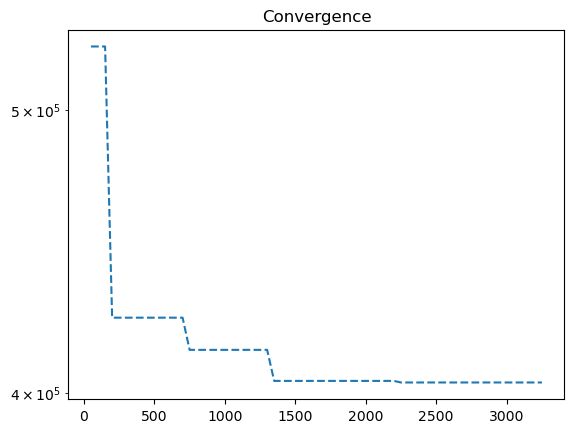

In [23]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title('Convergence')
plt.plot(n_evals, opt, '--')
plt.yscale('log')
plt.show()

# todo

Comenzar a buscar parámetros óptimos y documentar los resultados (La solución es óptima?) 